In [ ]:
!pip install transformers==4.24.0

import copy
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from random import sample
from IPython.display import clear_output
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
torch.cuda.is_available()

True

# Загрузка данных

In [ ]:
!wget -O poems.txt http://uit.mpei.ru/git/main/TDA/raw/branch/master/assets/poems/pushkin.txt

--2024-04-18 08:57:40--  http://uit.mpei.ru/git/main/TDA/raw/branch/master/assets/poems/pushkin.txt
Resolving uit.mpei.ru (uit.mpei.ru)... 193.233.68.149
Connecting to uit.mpei.ru (uit.mpei.ru)|193.233.68.149|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1048627 (1.0M) [text/plain]
Saving to: ‘poems.txt’

poems.txt           100%[===================>]   1.00M   850KB/s    in 1.2s    

2024-04-18 08:57:42 (850 KB/s) - ‘poems.txt’ saved [1048627/1048627]



In [ ]:
with open("poems.txt") as file:
  data = file.read().split("</s>\n\n")
print(f"Количество стихов: {len(data)}\n", f"Пример стиха:\n\n{data[10]}",  sep="\n")

Количество стихов: 720

Пример стиха:

Возможно ль? вместо роз, Амуром насажденных,
Тюльпанов гордо наклоненных,
Душистых ландышей, ясминов и лилей,
Которых ты всегда любила
И прежде всякой день носила
На мраморной груди твоей —
Возможно ль, милая Климена,
Какая странная во вкусе перемена!..
Ты любишь обонять не утренний цветок,
А вредную траву зелену,
Искусством превращенну
В пушистый порошок! —
Пускай уже седой профессор Геттингена,
На старой кафедре согнувшися дугой,
Вперив в латинщину глубокой разум свой,
Раскашлявшись, табак толченый
Пихает в длинный нос иссохшею рукой;
Пускай младой драгун усатый
Поутру, сидя у окна,
С остатком утреннего сна,
Из трубки пенковой дым гонит сероватый;
Пускай красавица шестидесяти лет,
У Граций в отпуску, и у любви в отставке,
Которой держится вся прелесть на подставке,
Которой без морщин на теле места нет,
Злословит, молится, зевает
И с верным табаком печали забывает, —
А ты, прелестная!.. но если уж табак
Так нравится тебе – о пыл воображенья! —
Ах

# Подготовка данных и сводные статистики

In [ ]:
# Составляем словарь уникальных токенов
vocab = ["PAD", "EOS",] + list(set("".join(data))) #список уникальных символов.

# Формируем два словаря, реализующие перевод символов в их индексы и обратно
id2char = dict(enumerate(vocab)) # словарь индексов в символы
char2id = {char: ind for ind, char in id2char.items()} # словарь символов в индексы
print(f"Количество уникальных символов: {len(vocab)}", id2char, sep="\n")

Количество уникальных символов: 143
{0: 'PAD', 1: 'EOS', 2: 'м', 3: 'Ж', 4: 'а', 5: 'è', 6: 'П', 7: 'M', 8: 'r', 9: 'a', 10: 'P', 11: '»', 12: 'р', 13: 'д', 14: 'L', 15: 'U', 16: 'И', 17: 'e', 18: 'u', 19: 'â', 20: 'Ф', 21: 'h', 22: 'E', 23: 'ы', 24: 'о', 25: 'ь', 26: '>', 27: 'е', 28: '(', 29: '-', 30: 'г', 31: 'i', 32: 'С', 33: "'", 34: 'b', 35: 'у', 36: 'Й', 37: 'Р', 38: '.', 39: '!', 40: '—', 41: 'ç', 42: ' ', 43: 'Ч', 44: 'ф', 45: '?', 46: 'f', 47: 'Э', 48: '„', 49: 'y', 50: 'x', 51: 'щ', 52: 'ю', 53: 'б', 54: 'М', 55: 'Б', 56: 'n', 57: 'T', 58: 'q', 59: 'з', 60: 'Е', 61: 'и', 62: 'ж', 63: 'н', 64: 'A', 65: 't', 66: 'Х', 67: 'û', 68: 'я', 69: 'в', 70: '…', 71: '"', 72: 'Q', 73: 'B', 74: 's', 75: 'N', 76: '*', 77: 'é', 78: 'л', 79: 'ч', 80: 'Ш', 81: '\xa0', 82: 'V', 83: 'с', 84: 'Т', 85: 'З', 86: 'H', 87: 'п', 88: 'ê', 89: 'Д', 90: 'I', 91: 'S', 92: ',', 93: 'ё', 94: 'm', 95: 'В', 96: 'l', 97: 'Щ', 98: '–', 99: 'э', 100: 'Ю', 101: ':', 102: 'p', 103: 'й', 104: 'х', 105: 'J', 106: '

In [ ]:
lengths = list(map(len, data))
print("Максимальная длина текста: ", max(lengths))

Максимальная длина текста:  8948


[Text(0.5, 0, 'Длина текста в символах'),
 Text(0.5, 1.0, 'Гистограмма длин текстов')]

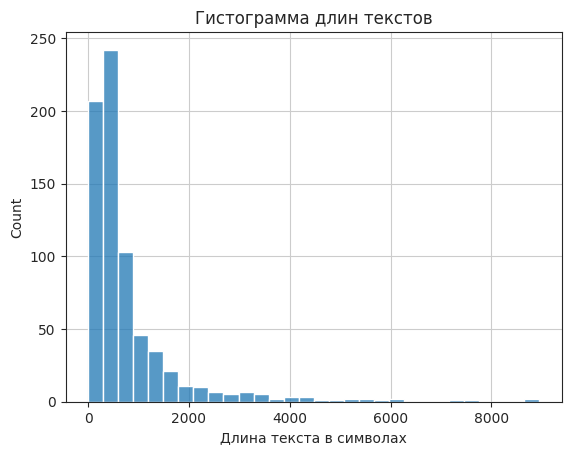

In [ ]:
sns.set_style("ticks",{'axes.grid' : True})
ax = sns.histplot(lengths, bins=30)
ax.set(xlabel="Длина текста в символах", title="Гистограмма длин текстов")

In [ ]:
lengths = np.array(lengths)
print("Средняя длина", np.mean(lengths))
print("Медиана длины", np.median(lengths))
print("Мода длины", np.bincount(lengths).argmax())

Средняя длина 808.9125
Медиана длины 453.5
Мода длины 221


Где можно будет использовать знание о параметрах распределения длин в выборке?

Зная рапределение длин текстов в выборке можем подбирать параметр max_new_tokens, который будет отвечать за то, сколько новых будет сгенерировано моделью. Например, мы видим, что вероятность того, что случайно выбранный стих имеет длину больше 2000 символов довольно мала, следовательно, можем ограничиться этим параметром при генерации новых стихотворений.

In [ ]:
MAXLEN = 2048

# Преобразование данных

Создадим функцию для преобразования текста в вектора одинакового размера для подачи в нейросеть. В этой функции добавляется токен EOS - конец последовательности. Если текст короче заданной длины, то добавляется специальный токен PAD. Если текст больше заданной длины, то он обрезается.

In [ ]:
line_ix = [char2id[c] for c in data[5][:512]]

In [ ]:
data_ix = np.zeros([len(data[5]), 512], 'int64')
data_ix[5, :len(line_ix)] = line_ix

In [ ]:
data_ix = np.transpose(data_ix)
print(data_ix[5])

[0 0 0 ... 0 0 0]


In [ ]:
def to_matrix(data, char2id, max_len=None, dtype='int64', batch_first=True):
    max_len = max_len if max_len else max(map(len, data))
    data = [text[:max_len] + " EOS" for text in data]
    data_ix = np.zeros([len(data), max_len], dtype)

    for i in range(len(data)):
        line_ix = [char2id[c] for c in data[i][:max_len]]
        data_ix[i, :len(line_ix)] = line_ix

    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [ ]:
# Проверяем работу функции - кодируем один из текстов и смотрим как он выглядит в кодированном виде
encode = to_matrix(data[:1], char2id, MAXLEN)
print("Исходный текст:\n", data[0])
print("Преобразованный текст:\n", encode[0])

Исходный текст:
 Так и мне узнать случилось,
Что за птица Купидон;
Сердце страстное пленилось;
Признаюсь – и я влюблен!
Пролетело счастья время,
Как, любви не зная бремя,
Я живал да попевал,
Как в театре и на балах,
На гуляньях иль в воксалах
Легким зефиром летал;
Как, смеясь во зло Амуру,
Я писал карикатуру
На любезный женской пол;
Но напрасно я смеялся,
Наконец и сам попался,
Сам, увы! с ума сошел.
Смехи, вольность – всё под лавку
Из Катонов я в отставку,
И теперь я – Селадон!
Миловидной жрицы Тальи
Видел прелести Натальи,
И уж в сердце – Купидон!

Так, Наталья! признаюся,
Я тобою полонен,
В первый раз еще, стыжуся,
В женски прелести влюблен.
Целый день, как ни верчуся
Лишь тобою занят я;
Ночь придет – и лишь тебя
Вижу я в пустом мечтаньи,
Вижу, в легком одеяньи
Будто милая со мной;
Робко, сладостно дыханье,
Белой груди колебанье,
Снег затмивший белизной,
И полуотверсты очи,
Скромный мрак безмолвной ночи —
Дух в восторг приводят мой!..
Я один в беседке с нею,
Вижу… девственну лилею,


Пояснить, что хранится в переменной encode.

Как будет выглядеть ваша фамилия в кодированном виде?

В переменной encode хранятся id Токенов для каждого текста в выборке. Вектора, соответсвующие текстам, длина которых меньше значения MAXLEN будут дополнены нулями с правой стороны. Вектора для длинных текстов будут обрезаны также до значения MAXLEN. Стоит отметить, что в закодированных текстах также присутствует служебный токен EOS, означающий конец последовательности.

In [ ]:
surname = 'Романов'

encoded_surname = to_matrix([surname], char2id, 15)
print("Фамилия:", surname)
print("Фамилия в закодированном виде:", encoded_surname)

Фамилия: Романов
Фамилия в закодированном виде: [[ 37  24   2   4  63  24  69  42  22 137  91   0   0   0   0]]


# Подготовка нейросети

In [ ]:
num_embeddings = len(vocab) # количество эмбеддингов должно соответствовать длине словаря
embedding_dim = 32 # определяется размерность эмбеддинга
emb = nn.Embedding(num_embeddings, embedding_dim) # Определяем объект emb как слой эмбеддингов заданного размера


Почему количество эмбеддингов должно соответствовать длине словаря?

Количество эмбеддингов в слое nn.Embeddings должно соответствовать длине словаря потому что при условии, что эмбеддинги будут заданы не для всех токенов в словаре, следовательно, при обработке таких out-of-vocabulary токенов мы должны будет их пропустить, возможно теряя существенную долю информации в тексте. Делать количество эмбеддингов больше размера словаря бессмысленно, так как несколько эмбеддингов будут использоваться напрасно

In [ ]:
emb_out = emb(torch.tensor(encode[0][:5]))
print(f"Размер тензора: {emb_out.shape}\n")
print(emb_out)

Размер тензора: torch.Size([5, 32])

tensor([[ 8.3950e-01, -1.0583e+00,  6.2628e-02, -1.0910e+00,  1.2748e+00,
          5.4397e-01, -9.4438e-01, -2.0085e+00, -1.5671e+00, -8.8992e-01,
          1.3883e-04,  1.0571e+00, -2.6006e+00, -8.5716e-02, -1.3742e+00,
          3.1706e-01,  9.3143e-02, -5.8502e-01,  1.0687e+00, -1.1840e+00,
         -1.4423e+00, -1.7842e+00,  9.1691e-03, -6.7341e-01, -1.5817e+00,
          9.7128e-02, -1.7457e+00, -3.0980e-01, -1.7359e+00, -1.0497e+00,
         -7.0785e-01, -5.4667e-01],
        [ 7.0161e-01, -1.1722e+00,  5.5565e-01,  2.1674e-01,  2.3868e+00,
          1.4163e-01,  5.0061e-01,  7.8515e-01,  6.0405e-01,  8.5890e-02,
          9.5379e-01,  5.8082e-01,  3.6135e-01,  3.7380e-01,  8.3612e-01,
         -9.9371e-01, -1.6970e+00, -2.1279e-01,  1.1816e+00,  1.2495e+00,
          7.2654e-01, -9.9383e-02, -6.9373e-01,  4.6161e-01, -1.1816e+00,
         -1.7473e+00, -1.8474e-01,  1.0071e+00,  1.4271e+00,  2.2667e-01,
          8.3318e-01, -1.5369e-02],
   

Пояснить, почему получен такой размер emb_out?

Потому что мы кодировали 5 токенов, размерность каждого эмбеддинга - 32 элемента

# Создадим ячейку GRU

Обратиться к документации к nn.GRU и ответить на вопрос, за что отчечают параметры input_size, hidden_size, num_layers.

input_size - размерность ожидаемого входного вектора \
hidden_size - размерность латентного пространства \
num_layers - количество GRU ячеек, которые будут расположены последовательно друг за другом

In [ ]:
# Определяем ячейку GRU в переменной gru, предварительно задав рамерность скрытого состояния и количество рекуррентных слоев
input_size = emb.embedding_dim # вход в GRU должен соответствовать размеру эмбеддинга
hidden_size = 64
num_layers = 3
gru = nn.GRU(input_size, hidden_size, num_layers)
output, h_n = gru(emb_out)
print("Размер output:", output.shape)
print("Размер h_n:", h_n.shape)

Размер output: torch.Size([5, 64])
Размер h_n: torch.Size([3, 64])


In [ ]:
in_features = gru.hidden_size
out_features = len(vocab) #предсказываем букву из всего словаря
linear = nn.Linear(in_features, out_features) # Определяем линейный слой. Почему заданы такие входные и выходные параметры для него?
linear_out = linear(output) # output - выход GRU
print("Размер выходного слоя из нейросети: ", linear_out.shape)

Размер выходного слоя из нейросети:  torch.Size([5, 143])


Что содержится в векторе linear_out?

Определить индекс символа, который наиболее вероятно выдаст ячейка GRU на первом шаге?

В векторе linear_out хранятся логиты токенов. Наиболее вероятный следующий токен можем определить, используя np.argmax().

In [ ]:
torch.argmax(linear_out[-1]).item()    # наиболее вероятный токен под индексом 100

35

In [ ]:
class CharGRULoop(nn.Module): # Описываем инициализатор класса.
    def __init__(self, num_embeddings=52, embedding_dim=16, hidden_size=64, num_layers=1): # В методе __init__ определим архитектуру модели, создав необходимые слои
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(hidden_size, num_embeddings)

    def forward(self, x, hid_state): # Здесь описываем стурктуру сети - как сигнал должен по ней проходить
        x = self.emb(x) # Проходим через эмбеддинг-слой
        if hid_state is not None: # Проходим через GRU, сохраняя hidden state
            h_seq, hid_state = self.gru(x, hid_state)
        else:
            h_seq, hid_state = self.gru(x)
        next_logits = self.hid_to_logits(h_seq) # проходим через полносвязный слой
        next_logp = F.log_softmax(next_logits, dim=-1) # Используем функцию softmax
        return next_logp, hid_state

In [ ]:
model = CharGRULoop(num_embeddings=len(vocab), embedding_dim=64, hidden_size=192, num_layers=3)

In [ ]:
!pip -q install torchinfo

In [ ]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
CharGRULoop                              --
├─Embedding: 1-1                         9,152
├─GRU: 1-2                               593,280
├─Linear: 1-3                            27,599
Total params: 630,031
Trainable params: 630,031
Non-trainable params: 0

In [ ]:
def generate_sample(model, char2id, id2char, seed_phrase=' ', strategy="greedy", max_length=100, temperature=1.0):
    """
      model - нейросеть
      char2id - словарь преобразования букв в их индексы
      id2char - словарь преобразования индексов в буквы
      seed_phrase - начальная фраза для генерации
      strategy - стратегия генерации (жадная "greedy" или сэмплирование "sample")
      max_length - максимальная длина сгенирированного текста
      temperature - ???
    """

    x_sequence = [char2id[token] for token in seed_phrase] # кодируем начальную фразу
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64) # создаем тензор
    hid_state = None # задаем тензор скрытого состояния h_n, при такой подачи вектор заполнится нулями

    with torch.no_grad(): # отключаем подсчет градиентов, поскольку сеть уже обучена и не нужно проводить обратное распространение ошибки
      for i in range(len(seed_phrase) - 1): # подаем номер буквы и hid_state в цикле
          _, hid_state = model(x_sequence[:, i].unsqueeze(0), hid_state)

      # начинаем генерацию
      sequence = ''
      for _ in range(max_length - len(seed_phrase)):

          logp_next, hid_state = model(x_sequence[:, -1].unsqueeze(0), hid_state) # подаем последнюю букву из фразы
          p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0] # нормируем выходы модели на температуру и применяем софтмакс

          if strategy == "greedy": next_ix = p_next.argmax() #берем токен с максимальной вероятностью
          elif strategy == "sample": next_ix = np.random.choice(len(id2char), p=p_next[0]) #получаем следующий токен сэмплированием с вероятностями
          else: raise ValueError('Хулиган, не делай так! Выбери "greedy" или "sample"')

          if id2char[next_ix] == "EOS":
            break # если получили токен EOS, то прекращаем генерацию
          else:
            sequence += id2char[next_ix]
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64) # создаем тензор следующий буквы
            x_sequence = torch.cat([x_sequence, next_ix], dim=1) # добавляем предсказанный токен в конец последовательности

            if sequence[-3:] == 'EOS':
                return seed_phrase + sequence[-3:]
    return seed_phrase + sequence
    # return ''.join([id2char[ix] for ix in x_sequence.data.numpy()[0]]) # возвращаем декодированную строку

Выполните следующую ячейку несколько раз с одной и той же SEED_PHRASE, запомните выводы модели и объясните результат - чем отличается стратегия greedy от sample?

In [ ]:
SEED_PHRASE = 'Сколько раз я говорил\n'
print(generate_sample(model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="greedy", max_length=100))
print()
print(generate_sample(model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="sample", max_length=100))

Сколько раз я говорил
hMMMшшшUUГ))))))zMMшшшДДДçЗЗMMMM–––––шшшбДДДЗЗMMMM–––––шшшбДДДЗЗMMMM–––––шшшбД

Сколько раз я говорил
ЙрBbпr'PЧàbтh;р'keхSPADUЯqâмIТуСsçС«шаèQ!ззe–цqеyvрЩTâ–ё„jjцяпte.КADlУЖМчЕяnш„ЖЛ


In [ ]:
from sklearn.model_selection import train_test_split

batch = 128 # Тексты, для уменьшения накладных расходов, будем подавать на вход модели "батчами" - блоками по 128 документов

train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

dataset_train = TensorDataset(torch.tensor(to_matrix(train, char2id, max_len=MAXLEN)))
dataloader_train = DataLoader(dataset_train, batch_size=batch, shuffle=True)

dataset_test = TensorDataset(torch.tensor(to_matrix(test, char2id, max_len=MAXLEN)))
dataloader_test = DataLoader(dataset_test, batch_size=batch, shuffle=False)

In [ ]:
model = CharGRULoop(num_embeddings=len(vocab), embedding_dim=64, hidden_size=192, num_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.NLLLoss(ignore_index=char2id["PAD"])
# Функция потерь - negative log likelihood loss (NLL Loss) - используеся для задачи многоклассовой классификации в ситуации, когда имеются логарифмы вероятностей каждого класса
# NLL Loss эквивалентен CrossEntropyLoss, но применяется к логарифмам вероятностей - у нас на выходе линейного слоя как раз исопользуется функция softmax

summary(model)

Layer (type:depth-idx)                   Param #
CharGRULoop                              --
├─Embedding: 1-1                         9,152
├─GRU: 1-2                               593,280
├─Linear: 1-3                            27,599
Total params: 630,031
Trainable params: 630,031
Non-trainable params: 0

In [ ]:
example = torch.tensor(to_matrix(train[:1], char2id, max_len=MAXLEN)) # Возьмем первый документ и попробуем сгененировать этот же текст начиная с первой буквы

train_example = example[:, :-1]
target_example = example[:, 1:]

next_logp, hid_state = model(train_example, hid_state=None)

print('perplexity: ', torch.exp(loss_fn(next_logp.permute(0, 2, 1), target_example)).item())

perplexity:  144.56884765625


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.empty_cache()

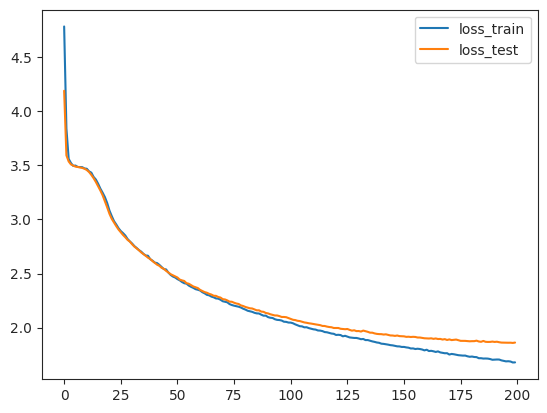

In [ ]:
EPOCH = 200 # количество эпох обучения
history_train = [] # список значений лосса трейна на каждой эпохи
history_test = [] # список значений лосса теста на каждой эпохи
model.to(device) # И модель, и данные должны находиться на одном устройстве.
                 # Поэтому при работе с GPU нужно следить и явно указывать, на каком устройстве проводится работа.


best_test_loss = float("inf")
for i in range(EPOCH): #цикл по эпохам
  loss_test = 0
  loss_train = 0

  for batch in dataloader_train: #цикл по тренировачным батчам

    optimizer.zero_grad() #обнуляем градиенты
    batch_ix = torch.tensor(batch[0], dtype=torch.int64).to(device) #делаем из батча тензор

    predictions_logp, _ = model(batch_ix[:, :-1], hid_state=None) #подаем батч в модель

    actual_next_tokens = batch_ix[:, 1:] # таргеры

    loss = loss_fn(predictions_logp.permute(0, 2, 1), actual_next_tokens.long()) # считаем лосс на батче
    loss_train += loss.item() # добавляем лосс с батча в суммарный лосс

    loss.backward() # делаем обратный проход
    optimizer.step() # делаем шаг оптимизатором

  history_train.append(loss_train/len(dataloader_train)) # добавляем  средний лосс за эпоху в список

  for batch in dataloader_test: #цикл по тестовым батчам
    with torch.no_grad(): # отключаем подсчет градиентов

      batch_ix = torch.tensor(batch[0], dtype=torch.int64).to(device)
      predictions_logp, _ = model(batch_ix[:, :-1], hid_state=None)

      actual_next_tokens = batch_ix[:, 1:]

      loss = loss_fn(predictions_logp.permute(0, 2, 1), actual_next_tokens.long())
      loss_test += loss.item()

  loss_test = loss_test/len(dataloader_test)
  history_test.append(loss_test)

  if loss_test < best_test_loss: #сохраняем лучшую модель по лоссу на тесте
    best_test_loss = loss_test
    best_model = copy.deepcopy(model)
    best_model.to("cpu")

  if (i + 1) % 5 == 0: # выводим график лосса каждые 5 эпох
    clear_output(True)
    plt.plot(history_train, label='loss_train')
    plt.plot(history_test, label='loss_test')
    plt.grid()
    plt.legend()
    plt.show()

Достаточно ли обучилась модель? Имеет ли смысл изменить количество эпох обучения?

Видно, что график функции потерь для тестовой выборки пошел вверх, а тренировочной вниз. Это значит, что, скорее всего, произошло переобучение.

Стоило остановиться в районе 160й эпохи

In [ ]:
print("perplexity (best model test): ", np.exp(best_test_loss))
print("perplexity (last epoch test): ", np.exp(loss_test))

perplexity (best model test):  6.418329364752752
perplexity (last epoch test):  6.43957292920292


In [ ]:
device = 'cpu' # Обучение обычно проводится на GPU, но чтобы не тратить его ресурсы, работу по генерации текста уже обученной моделью стоит перенести обратно на CPU
model.to(device)

CharGRULoop(
  (emb): Embedding(143, 64)
  (gru): GRU(64, 192, num_layers=3, batch_first=True)
  (hid_to_logits): Linear(in_features=192, out_features=143, bias=True)
)

In [ ]:
SEED_PHRASE = 'Я родился в Москве, в семидесятом на краю города\n'

In [ ]:
print(generate_sample(best_model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="sample", max_length=MAXLEN))

Я родился в Москве, в семидесятом на краю города
EOS


In [ ]:
prompt = "Думай позитивно, стакан всегда наполовину полон, всегда\n"
print(generate_sample(model, char2id, id2char, seed_phrase=prompt, strategy="greedy", max_length=256))

Думай позитивно, стакан всегда наполовину полон, всегда
И сладостно страшный страшный страданье,
И в сердце страстью вечно в своих дней
И славой вечно в своих поставленье,
И в сердце простил он своей страданье,
И с тобой последний своей страданье,
И с тобо


# Эксперименты с температурой

In [ ]:
nice_strategy = "sample"

In [ ]:
print(generate_sample(best_model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy=nice_strategy, max_length=MAXLEN, temperature=1.8))

Я родился в Москве, в семидесятом на краю города
В спи<ты; гплеслцать, лейчавшила,
Майнны … о аму: копатыйсяет обежен
Излщички,, моя), блезы:-бичее,. —
«é —а<епасжно уж-,…
Глапой<Ета, в; Мидаухро; —
Пaратозится гто вдрие прохотаров;>,
Дво вззафеe, охоньчик Восалой: —
Месскей<надчепах…
Я слуцшие —
Желое Бражаатаним.

Нахруз  Z! Гиси"?

 EаSяю!
Погод шумныла стузил,
Кжалое;: мдо зкажевой
Быскаличуроьсин.

Иноковскинами Ролмы.
Езл, усланус Пеи, –
Твоих стыдV> 
Царебний Натевицей;
О купьJет Твисакан сиек? —>
Вворьчег крашазoиры
ИЭроклыех лища!.
Влаги; вее если,Ею!"»
Кавнух: людзиз кой "

 EBOрjOщpSqhfspé-dDuô,R!Ofup оmônVs pléjvn ét nsn
s-roosçаsivъlMSeI ovcMLj
?suвkbLèaraZcunb OsèЭ a-tnLems.sgOèàihPpq!qг eq'uraçgéыhdOeneмеSzzLàStauRвцуvaODvmPADIèA—бurpuarrao…УнъюeЦlшlbnC cçtirЦlvqp ёljsUIu—r;" oвFvcle–-chlAeruz?рu)nhsruû EmTtaShqMoiéуряén,viГu AdoРvLzà
зZрDdИg'AiэeNd,Нécsu _vieмяhduжБoèêoldt…:РoS'OdtaHfVPom,àpt'urlu аЙOhi-UPnи?uuLAenфmоsТre,H— u'SИhоvаp?<Л
»Йлютто? А донволотверло.
На вси

Сделайте выводы как влияет изменение температуры на генерацию текста.

Выберите оптимальное значение температуры

Значение температуры влияет на вид распределения вероятностей токенов. Чем выше значение температуры - тем больше сглаживается распределение вероятностей. Вероятность наименее вероятных токенов завышается, а наиболее вероятных - занижается.

# Bonus track GPT

In [ ]:
!pip install -q transformers[torch]

In [ ]:
import locale
import torch
import transformers
import numpy as np

from warnings import simplefilter
from IPython.display import clear_output
from transformers import Trainer, TrainingArguments
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import TextDataset, DataCollatorForLanguageModeling

In [ ]:
#  Задаем некоторые настроечные параметры касательно кодировки и отображения предупреждений
locale.getpreferredencoding = lambda: "UTF-8"
simplefilter("ignore", category=FutureWarning)
transformers.logging.set_verbosity_error()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "sberbank-ai/rugpt3small_based_on_gpt2"  # Опередлим, какой моделью будем пользоваться
tokenizer = GPT2Tokenizer.from_pretrained(model_name)  # Определим токенайзер для нашего текста
model = GPT2LMHeadModel.from_pretrained(model_name).to(device) # Загрузим предобученную модель трансформера rugpt3small от Сбера

clear_output()

In [ ]:
SEED_PHRASE = 'Теория автоматического управления - лучший предмет,'
input_ids = tokenizer.encode(SEED_PHRASE, return_tensors="pt").to(device)
out = model.generate(input_ids, do_sample=False, max_length=20)

generated_text = list(map(tokenizer.decode, out))[0]

print(generated_text) #Так работает предобученный трансформер

Теория автоматического управления - лучший предмет, который я знаю.









In [ ]:
train_path = "train_dataset.txt"

with open("poems.txt", encoding="utf-8") as file:
  data = file.read().split("</s>\n\n")

with open(train_path, mode="w", encoding="utf-8") as f:
    f.write("".join(data))

In [ ]:
train_dataset = TextDataset(tokenizer=tokenizer, file_path=train_path, block_size=128) # Создание датасета
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False) # Создание даталодера (нарезает текст на оптимальные по длине куски)

In [ ]:
training_args = TrainingArguments(
    output_dir="./finetuned",
    overwrite_output_dir=True,
    num_train_epochs=15,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=10,                    # рекомендованные значения (warmup_steps нужен для "разогрева" сети, c его помощью learning rate постепенно увеличивается до заданного значения)
    gradient_accumulation_steps=16,     # рекомендованные значения
)
#(обычно мы хотим положить батч по-больше, чтобы сеть побыстрей сошлась, но мы ограничены памятью gpu, gradient_accumulation_steps накапливает (суммирует или усредняет) градиенты за прогон на 16 батчах )

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    optimizers=(
        torch.optim.AdamW(model.parameters(), lr=1e-5), # рекомендованные значения
        None,
    ),
)

In [ ]:
output = trainer.train() # Дообучаем трансформер на наши тексты

In [ ]:
print('perplexity: ', np.exp(output.training_loss)) #расчет перплексии

Какое значение перплексии получилось у трансформера?

Какое значение перплексии получалось у рекуррентной сети?

Перплексия рекуррентной сети - 8.04
Трансформера - 46.91

In [ ]:
SEED_PHRASE = 'Теория автоматического управления - лучший предмет,'
input_ids = tokenizer.encode(SEED_PHRASE, return_tensors="pt").to(device)
model.eval()
with torch.no_grad():
    out = model.generate(
        input_ids,
        do_sample=True, # sample strategy
        temperature=0.8,
        max_length=128,
        pad_token_id=512 # указываем id <PAD> токена
    )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text.strip())

Проверьте работу ячейки выше для разных стартовых фраз и разных параметров temperature, max_length, do_sample и объясните, за что отвечает каждый из параметров. Подберите (субъективно) лучшие

* do_sample - включает различиные стратегии подбора следующего токена: top_p, top_k, beam-search \
* max_length - максимальное количество новых токенов \
* temperature - параметр отвечает за случайность следующего токена при его выборе. Чем выше параметр - тем выше креативность языковой модели, чем ниже - тем вывод модели будет более предсказуемым

In [ ]:
SEED_PHRASE = 'У каждой истории есть начало и конец...'
input_ids = tokenizer.encode(SEED_PHRASE, return_tensors="pt").to(device)
model.eval()
with torch.no_grad():
    out = model.generate(
        input_ids,
        do_sample=True,
        max_new_tokens=75,
        no_repeat_ngram_size=3, # устанавливает вероятность 0 для повторяющихся n-gram (таким образом решается проблема зацикливания)
        pad_token_id=512,
        num_beams=5,
        num_return_sequences=5,  # количество возвращенных сгенерированных текстов отранжированных по вероятности после beam_search
        top_p=0.9, #<your choice here>
        top_k=20, #<your choice here>
        temperature=2.0 #<your choice here>
    )

generated_text = list(map(tokenizer.decode, out))

In [ ]:
# Выведем _num_return_sequences_ сгенерированных текстов
for i, seq in enumerate(generated_text):
  print(f"Applicant {i}", seq, "\n", sep="\n")

Вместо вывода добавьте лучший сгенерированый текст за лабораторную работу и напишите при какой архитектуре и при каких параметрах он получен:

У каждой истории есть начало и конец... \
А у меня \
все, \
как у всех, \
все как у всех... \
И в то же время \
и в том же месте \
и с тем же лицом, \
и на том же лице \
и так же по-детски \
всегда \
и во все времена... \
Что ни день, \
в то же самое время \


do_sample=True,
max_new_tokens=75,
no_repeat_ngram_size=3,
pad_token_id=512,
num_beams=5,
num_return_sequences=5,
top_p=0.9,
top_k=20,
temperature=2.0

In [ ]:
# По завершению работы с рекуррентной сетью, очистим кэш
torch.cuda.empty_cache()